In [2]:
import os
import torch

os.environ["MKL_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="8"
os.environ["OMP_NUM_THREADS"]="1"

import sys
import json

import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from spatial.merfish_dataset import FilteredMerfishDataset, MerfishDataset, SyntheticDataset0, SyntheticDataset1, SyntheticDataset2, SyntheticDataset3
from spatial.models.monet_ae import MonetAutoencoder2D, TrivialAutoencoder, MonetDense
from spatial.train import train
from spatial.predict import test

from torch.profiler import profile, record_function, ProfilerActivity

# makes the notebook loadable
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import hydra
from hydra.experimental import compose, initialize

with open('../deepST_synthetic_results.json', 'r') as deepST:
    test_loss_rad_dict = json.load(deepST)

for model_architecture in [[512],[128,128,128],[512,512,512]]:
    for rad in range(0, 65, 5):
        for synthetic_exp in [0, 1, 4, 5, 6, 7]:
            if str((rad, synthetic_exp)) not in test_loss_rad_dict:
                test_loss_rad_dict[str((rad, synthetic_exp))] = {}
            with initialize(config_path=f"../../config"):
                cfg_from_terminal = compose(config_name=f"config{synthetic_exp}")
                OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", model_architecture)
                OmegaConf.update(cfg_from_terminal, "training.logger_name", f"synthetic{synthetic_exp}")
                OmegaConf.update(cfg_from_terminal, "radius", rad)
                OmegaConf.update(cfg_from_terminal, "model.kwargs.response_genes", [0])
                OmegaConf.update(cfg_from_terminal, "datasets.dataset.splits", 0)
                try:
                    output = test(cfg_from_terminal)
                except FileNotFoundError:
                    continue
                trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
                test_loss_rad_dict[str((rad, synthetic_exp))][str(model_architecture)] = test_results[0]['test_loss']

            with open('../deepST_synthetic_results.json', 'w') as deepST:
                json.dump(test_loss_rad_dict, deepST)

In [3]:
with open('../deepST_synthetic_results.json', 'r') as deepST:
    test_loss_rad_dict = json.load(deepST)

In [4]:
test_loss_rad_dict

{'(25, 0)': {'[512]': 0.10236034542322159,
  '[128, 128, 128]': 0.08310852199792862,
  '[512, 512, 512]': 0.08545476943254471,
  '[128, 128, 128, 128, 128, 128]': 0.06834235787391663},
 '(0, 0)': {'[512]': 0.23553942143917084,
  '[128, 128, 128]': 0.23567447066307068,
  '[512, 512, 512]': 0.23585249483585358,
  '[128, 128, 128, 128, 128, 128]': 0.23516948521137238},
 '(0, 1)': {'[512]': 0.06582453101873398,
  '[128, 128, 128]': 0.0657385066151619,
  '[512, 512, 512]': 0.06567420810461044,
  '[128, 128, 128, 128, 128, 128]': 0.0653681829571724},
 '(0, 4)': {'[512]': 0.00047063702368177474,
  '[128, 128, 128]': 0.0007368026999756694,
  '[512, 512, 512]': 0.0005545378662645817},
 '(0, 5)': {'[512]': 0.0009140346082858741,
  '[128, 128, 128]': 0.0011945620644837618,
  '[512, 512, 512]': 0.0009824539301916957},
 '(0, 6)': {'[512]': 0.0028924529906362295,
  '[128, 128, 128]': 0.0031361763831228018,
  '[512, 512, 512]': 0.0029509165324270725},
 '(0, 7)': {'[512]': 0.0032210680656135082,
  '[1

In [4]:
# update a model in test_loss_rad_dict
import hydra
from hydra.experimental import compose, initialize

for model_architecture in [[128,128,128,128,128,128]]:
    for rad in range(0, 65, 5):
        for synthetic_exp in ["Nonlinear"]:
            if str((rad, synthetic_exp)) not in test_loss_rad_dict:
                test_loss_rad_dict[str((rad, synthetic_exp))] = {}
            with initialize(config_path=f"../../config"):
                cfg_from_terminal = compose(config_name=f"config{synthetic_exp}")
                OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", model_architecture)
                OmegaConf.update(cfg_from_terminal, "training.logger_name", f"synthetic{synthetic_exp}")
                OmegaConf.update(cfg_from_terminal, "radius", rad)
                OmegaConf.update(cfg_from_terminal, "model.kwargs.response_genes", [0])
                OmegaConf.update(cfg_from_terminal, "datasets.dataset.splits", 0)
                OmegaConf.update(cfg_from_terminal, "training.filepath", f"{cfg_from_terminal.model.name}__{cfg_from_terminal.model.kwargs.hidden_dimensions}__{cfg_from_terminal.model.kwargs.response_genes}__{cfg_from_terminal.radius}__{cfg_from_terminal.training.logger_name}")
#                 OmegaConf.update(cfg_from_terminal, "model.kwargs.aggr", "add")
                if not os.path.exists(f"../../output/lightning_logs/checkpoints/MonetDense/{cfg_from_terminal.training.filepath}.ckpt"):
                    print(f"Could not find file: {cfg_from_terminal.training.filepath}")
                    continue
                output = test(cfg_from_terminal)
                trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
                print(inputs.shape, gene_expressions.shape)
                test_loss_rad_dict[str((rad, synthetic_exp))][str(model_architecture)] = test_results[0]['test_loss']

            with open('../deepST_synthetic_results.json', 'w') as deepST:
                json.dump(test_loss_rad_dict, deepST)

Could not find file: MonetDense__[128, 128, 128, 128, 128, 128]__[0]__0__syntheticNonlineartest
Could not find file: MonetDense__[128, 128, 128, 128, 128, 128]__[0]__5__syntheticNonlineartest
Could not find file: MonetDense__[128, 128, 128, 128, 128, 128]__[0]__10__syntheticNonlineartest
Could not find file: MonetDense__[128, 128, 128, 128, 128, 128]__[0]__15__syntheticNonlineartest
Could not find file: MonetDense__[128, 128, 128, 128, 128, 128]__[0]__20__syntheticNonlineartest
Could not find file: MonetDense__[128, 128, 128, 128, 128, 128]__[0]__25__syntheticNonlineartest
Could not find file: MonetDense__[128, 128, 128, 128, 128, 128]__[0]__30__syntheticNonlineartest
Could not find file: MonetDense__[128, 128, 128, 128, 128, 128]__[0]__35__syntheticNonlineartest
Could not find file: MonetDense__[128, 128, 128, 128, 128, 128]__[0]__40__syntheticNonlineartest
Could not find file: MonetDense__[128, 128, 128, 128, 128, 128]__[0]__45__syntheticNonlineartest
Could not find file: MonetDense_

In [4]:
with open('../LightGBM_synthetic_results.json', 'r') as linear:
    linear_models_dict = json.load(linear)

In [8]:
# import json

# with open('../sanity_check.json', 'r') as linear:
#     linear_models_dict = linear_models_dict | json.load(linear)

In [9]:
test_loss_rad_dict, linear_models_dict

({'(25, 0)': {'[512]': 0.10236034542322159,
   '[128, 128, 128]': 0.08310852199792862,
   '[512, 512, 512]': 0.08545476943254471,
   '[128, 128, 128, 128, 128, 128]': 0.06834235787391663},
  '(0, 0)': {'[512]': 0.23553942143917084,
   '[128, 128, 128]': 0.23567447066307068,
   '[512, 512, 512]': 0.23585249483585358,
   '[128, 128, 128, 128, 128, 128]': 0.23516948521137238},
  '(0, 1)': {'[512]': 0.06582453101873398,
   '[128, 128, 128]': 0.0657385066151619,
   '[512, 512, 512]': 0.06567420810461044,
   '[128, 128, 128, 128, 128, 128]': 0.0653681829571724},
  '(0, 4)': {'[512]': 0.00047063702368177474,
   '[128, 128, 128]': 0.0007368026999756694,
   '[512, 512, 512]': 0.0005545378662645817},
  '(0, 5)': {'[512]': 0.0009140346082858741,
   '[128, 128, 128]': 0.0011945620644837618,
   '[512, 512, 512]': 0.0009824539301916957},
  '(0, 6)': {'[512]': 0.0028924529906362295,
   '[128, 128, 128]': 0.0031361763831228018,
   '[512, 512, 512]': 0.0029509165324270725},
  '(0, 7)': {'[512]': 0.0032

In [5]:
# create dataframe
import pandas as pd

# linear models + XGBoost
data = pd.DataFrame(columns=['Model', 'Radius', 'Experiment #', 'L2 Loss'])
for k,v in linear_models_dict.items():
    k = k.split()
    entry = pd.DataFrame.from_dict({
        'Model': [k[0]],
        'Radius': [int(k[1])],
        'Experiment #': [k[2]],
        'L2 Loss': [v]
    })
    data = pd.concat([data, entry], ignore_index=True)

print(data)


for k,v in test_loss_rad_dict.items():
    try:
        k = eval(k)
        entry = pd.DataFrame.from_dict({
            'Model': 'deepST',
            'Radius': [int(k[0])],
            'Experiment #': [str(k[1])],
            'L2 Loss': [min(v.values())]
        })
        data = pd.concat([data, entry], ignore_index=True)
    #nonlinear case
    except (AttributeError, ValueError):
        entry = pd.DataFrame.from_dict({
            'Model': 'deepST',
            'Radius': [int(k[0])],
            'Experiment #': [str(k[1])],
            'L2 Loss': [v]
        })
        data = pd.concat([data, entry], ignore_index=True)
        

data[data["Model"] == "deepST"]

          Model Radius Experiment #   L2 Loss
0      LightGBM      0            0  0.229992
1           OLS      0            0  0.230439
2         Ridge      0            0  0.230426
3         Lasso      0            0  0.231350
4    ElasticNet      0            0  0.230434
..          ...    ...          ...       ...
817       Lasso     55          FDR  0.203158
818    LightGBM     60          FDR  0.001986
819         OLS     60          FDR  0.202371
820       Ridge     60          FDR  0.202371
821       Lasso     60          FDR  0.203158

[822 rows x 4 columns]


,Model,Radius,Experiment #,L2 Loss
822,deepST,25,0,0.068342
823,deepST,0,0,0.235169
824,deepST,0,1,0.065368
825,deepST,0,4,0.000471
826,deepST,0,5,0.000914
...,...,...,...,...
934,deepST,40,2,0.313488
935,deepST,45,2,0.311361
936,deepST,50,2,0.313585
937,deepST,55,2,0.307252


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

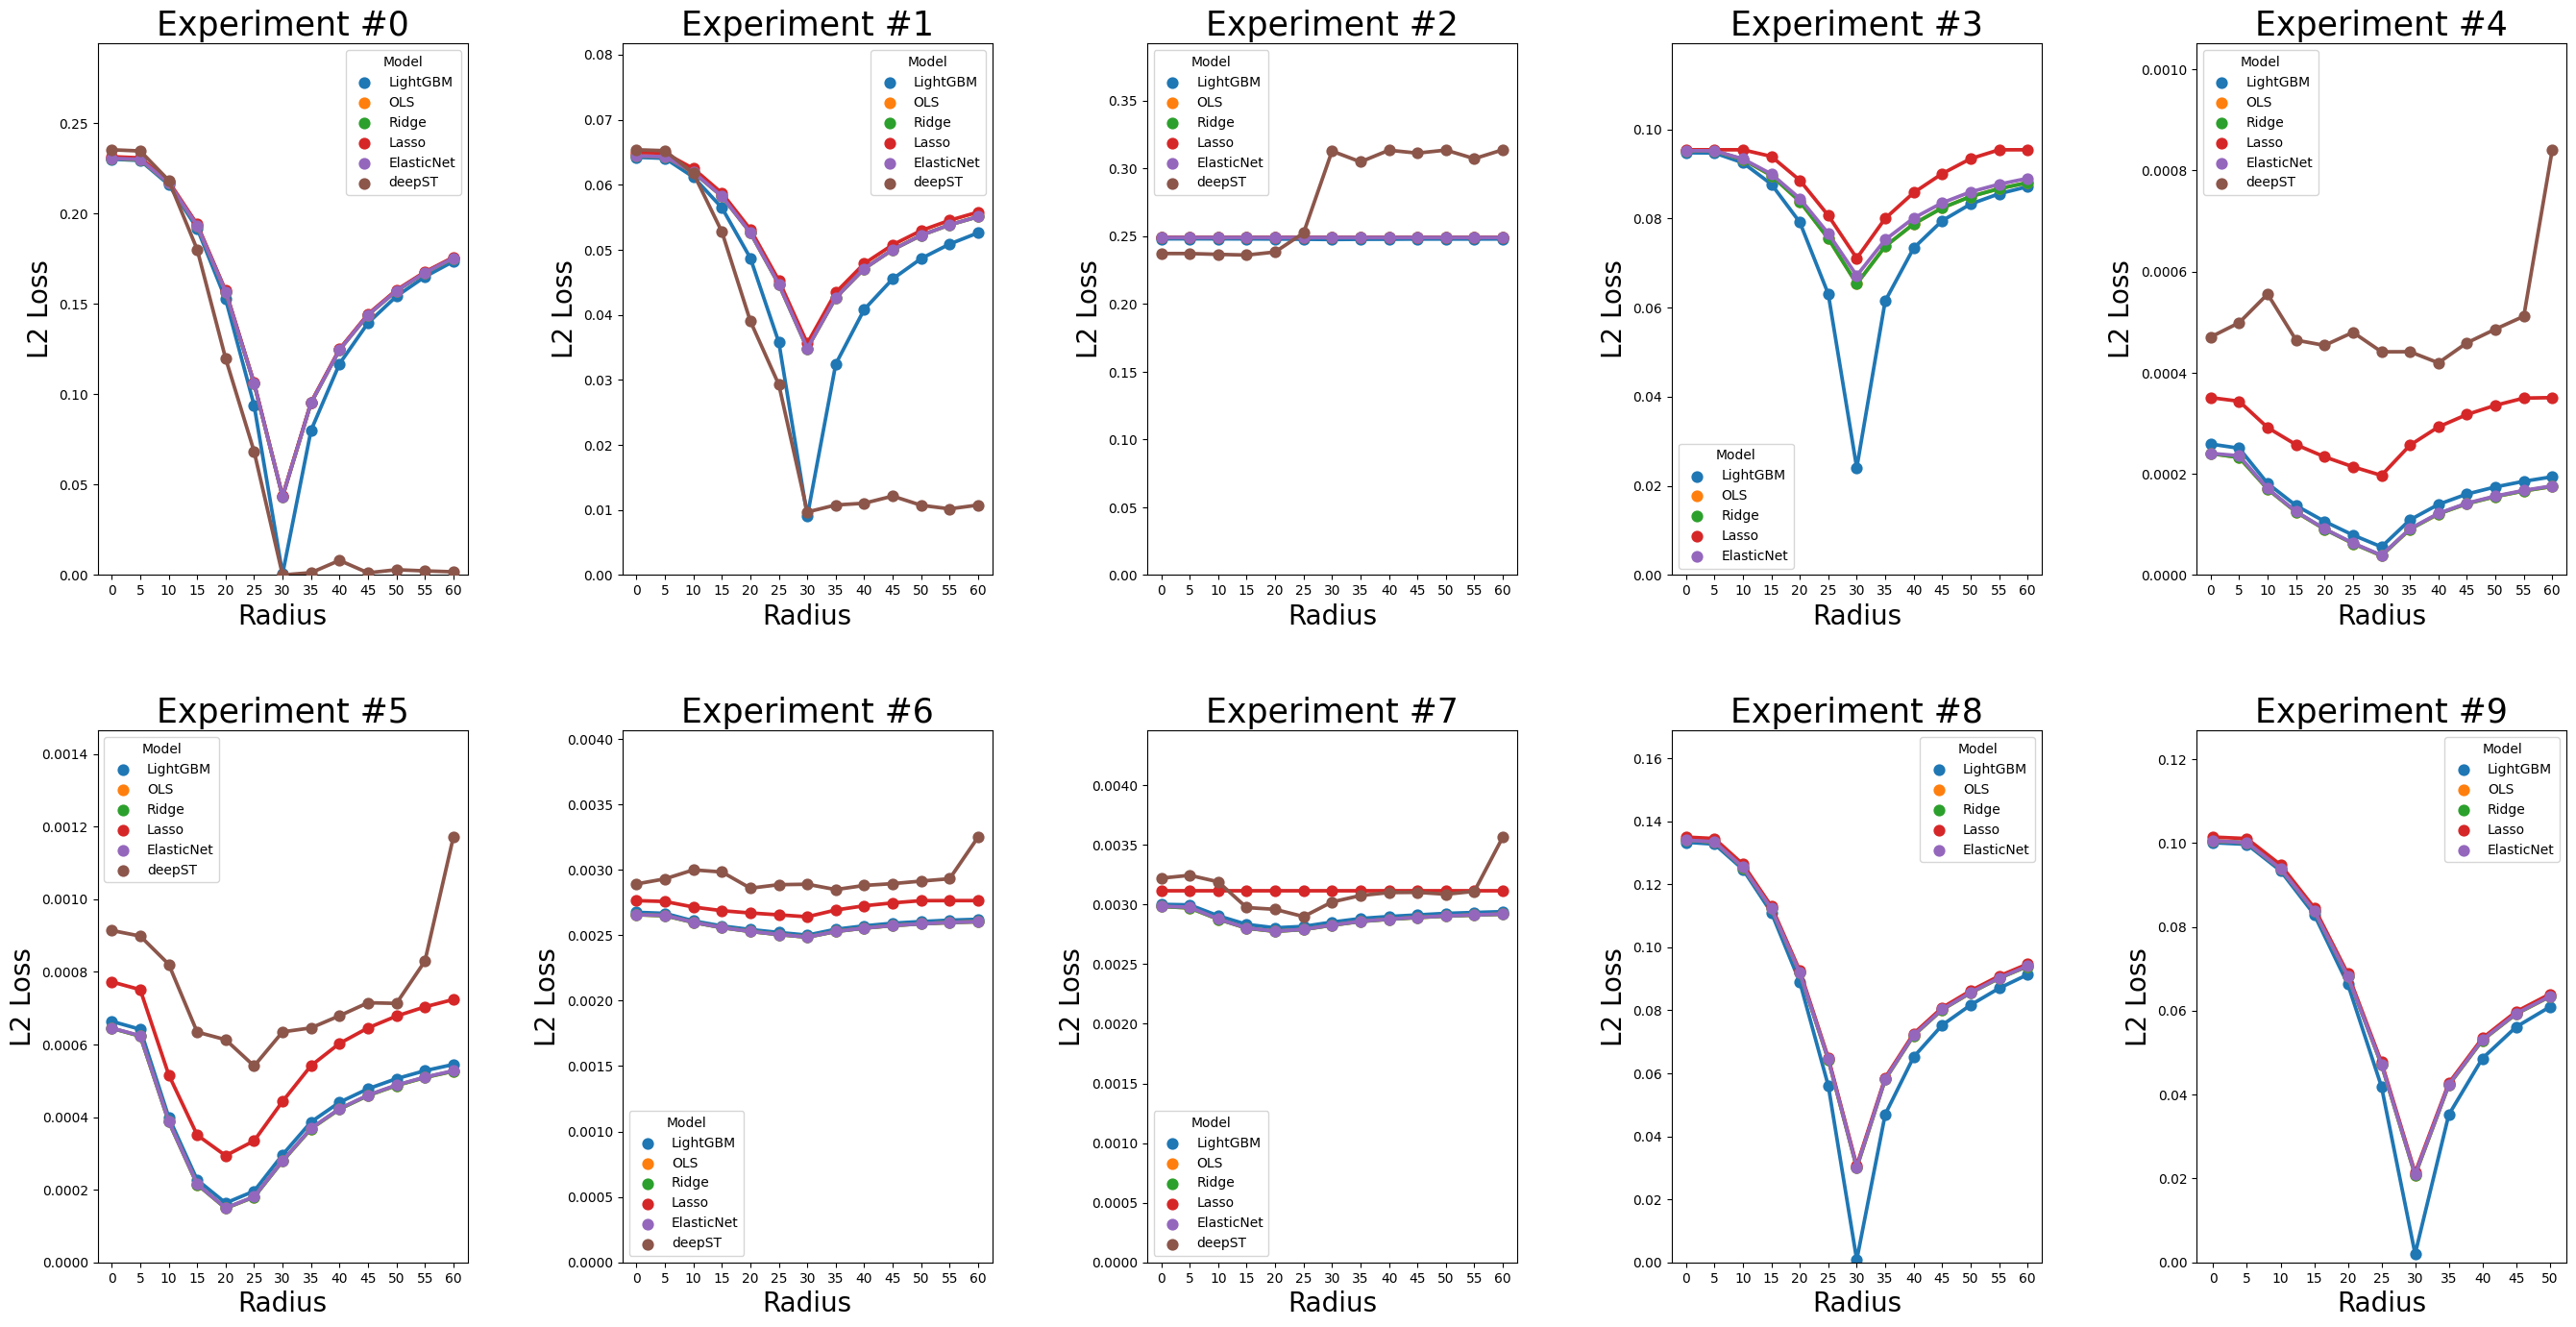

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(28, 15))   

# create pointplot
for exp in list(range(10)):
    new_data = data[data['Experiment #'] == str(exp)]
    synth_results = sns.pointplot(ax=axes[exp // 5, exp % 5], x='Radius', y= 'L2 Loss', hue='Model', data=new_data)
    axes[exp // 5, exp % 5].set_ylim(bottom=0, top=1.25*max(new_data["L2 Loss"]))
    # baseline = new_data[(new_data["Model"] == "deepST") & (new_data["Radius"] == 0)]["L1 Loss"]
    # synth_results.axhline(baseline.item(), linestyle = '-', linewidth=3)
    synth_results.set_title(f"Experiment #{exp}", fontsize=25)
    synth_results.set_xlabel("Radius", fontsize = 20)
    synth_results.set_ylabel("L2 Loss", fontsize = 20)
    fig.tight_layout(pad=5)
plt.savefig(f'synth_experiments.png')

In [2]:
import hydra
from hydra.experimental import compose, initialize

with open('../deepST_synthetic_results.json', 'r') as deepST:
    test_loss_rad_dict = json.load(deepST)

for rad in range(0,65,5):
    for synthetic_exp in [2]:
        for model_architecture in [[128, 128, 128, 128, 128, 128]]:
            if str((rad, synthetic_exp)) not in test_loss_rad_dict:
                test_loss_rad_dict[str((rad, synthetic_exp))] = {}
            with initialize(config_path=f"../../config"):
                cfg_from_terminal = compose(config_name=f"config{synthetic_exp}")
                OmegaConf.update(cfg_from_terminal, "gpus", [1])
                OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", model_architecture)
                OmegaConf.update(cfg_from_terminal, "training.logger_name", f"synthetic{synthetic_exp}")
                OmegaConf.update(cfg_from_terminal, "radius", rad)
                OmegaConf.update(cfg_from_terminal, "model.kwargs.response_genes", [0])
                OmegaConf.update(cfg_from_terminal, "datasets.dataset.splits", 0)
                OmegaConf.update(cfg_from_terminal, "optimizer.name", "Adam")
                OmegaConf.update(cfg_from_terminal, "model.kwargs.aggr", "sum")
#                 OmegaConf.update(cfg_from_terminal, "training.filepath", f"{cfg_from_terminal.model.name}__{cfg_from_terminal.model.kwargs.hidden_dimensions}__{cfg_from_terminal.radius}__{cfg_from_terminal.training.logger_name}__{cfg_from_terminal.optimizer.name}")
                if not os.path.exists(f"../../output/lightning_logs/checkpoints/MonetDense/{cfg_from_terminal.training.filepath}.ckpt"):
                    print(f"Could not find file: {cfg_from_terminal.training.filepath}")
                    continue
                output = test(cfg_from_terminal)
                trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
                test_loss_rad_dict[str((rad, synthetic_exp))][str(model_architecture)] = test_results[0]['test_loss']

            with open('../deepST_synthetic_results.json', 'w') as deepST:
                json.dump(test_loss_rad_dict, deepST)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:34<00:00,  1.43s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.23725612461566925
      test_loss_mse         0.23725612461566925
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|█████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:32<00:00,  1.36s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.23723779618740082
      test_loss_mse         0.23723779618740082
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|█████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:31<00:00,  1.33s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.23663219809532166
      test_loss_mse         0.23663219809532166
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|█████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:32<00:00,  1.36s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.23611831665039062
      test_loss_mse         0.23611831665039062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|█████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:32<00:00,  1.35s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2383788377046585
      test_loss_mse         0.2383788377046585
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|█████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:33<00:00,  1.38s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.252416729927063
      test_loss_mse          0.252416729927063
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|█████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:31<00:00,  1.32s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3128505349159241
      test_loss_mse         0.3128505349159241
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|█████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:32<00:00,  1.36s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3048882782459259
      test_loss_mse         0.3048882782459259
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|█████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:33<00:00,  1.38s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.31348833441734314
      test_loss_mse         0.31348833441734314
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|█████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:32<00:00,  1.37s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.31136074662208557
      test_loss_mse         0.31136074662208557
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|█████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:32<00:00,  1.37s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3135851323604584
      test_loss_mse         0.3135851323604584
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|█████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:33<00:00,  1.38s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3072521984577179
      test_loss_mse         0.3072521984577179
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|█████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:33<00:00,  1.40s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3138134181499481
      test_loss_mse         0.3138134181499481
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Synthetic Plotting

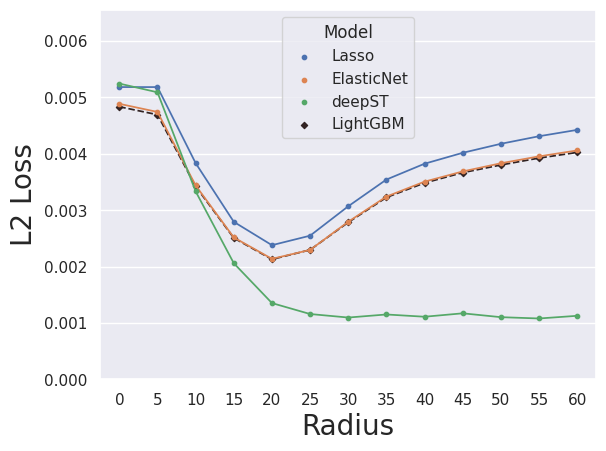

In [42]:
EXPERIMENT_NUM = "Nonlinear"

# Set styles before plotting
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set(rc={"lines.linewidth": 0.7})

# Create pointplot for all but the specific model
model_to_highlight = "LightGBM"
new_data = data[(data['Experiment #'] == EXPERIMENT_NUM) & ((data["Model"] != "OLS") & (data["Model"] != "Ridge") & (data['Model'] != model_to_highlight))]
synth_results = sns.pointplot(x='Radius', y='L2 Loss', hue='Model', data=new_data)

# Set the y-limits
synth_results.set_ylim(bottom=0, top=1.25*max(new_data["L2 Loss"]))

# Label and title configurations
synth_results.set_xlabel("Radius", fontsize=20)
synth_results.set_ylabel("MSE Loss", fontsize=20)

# Create pointplot just for the specific model to highlight
highlight_data = data[(data['Model'] == model_to_highlight) & (data['Experiment #'] == EXPERIMENT_NUM)]
sns.pointplot(x='Radius', y='L2 Loss', hue='Model', data=highlight_data, markers=["D"], linestyles=["--"], color="red", dodge=0.2)  # Use different markers and linestyles for emphasis if you like

# Save the plot
plt.savefig(f'synthetic{EXPERIMENT_NUM}.png', dpi=300, bbox_inches='tight')